In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sys  
sys.path.append("/Users/caihao/PycharmProjects/insight_project/")
from data.config import raw_data_dir, processed_data_dir, cleaned_data_dir

In [7]:
# merge preprocessed company and twitter data.
pd.set_option('display.max_columns', None)

company_df = pd.read_csv(processed_data_dir + '/companies_2014_series_ab_tweeted.csv')
twitter_df = pd.read_csv(processed_data_dir + '/tweets_2014_series_ab.csv')
df = pd.concat([company_df, twitter_df], axis=1)
print(df.columns)
print(df.head())

Index(['permalink', 'name', 'homepage_url', 'category_list', 'market',
       'funding_total_usd', 'status', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'twitter_username', 'first2last_funding_days',
       'twit_since', 'twit_until', 'series_a_date', 'preA_timespan',
       'postA_timespan', 'all_tweet_num', 'preA_tweet_num', 'postA_tweet_num',
       'preA_tweet_freq', 'postA_tweet_freq', 'preA_tweet_avglength',
       'postA_tweet_avglength', 'preA_tweet_content_richness',
       'postA_tweet_content_richness', 'preA_tweet_interactiveness',
       'postA_tweet_interactiveness'],
      dtype='object')
                   permalink         name               homepage_url  \
0      /organization/waywire     #waywire     http://www.waywire.com   
1    /organization/1daylater    1DayLater       http://1daylater.com   
2       /organization/20x

count     515.000000
mean      219.392233
std       463.748231
min         0.000000
25%         0.000000
50%         0.000000
75%       307.500000
max      5478.000000
Name: first2last_funding_days, dtype: float64


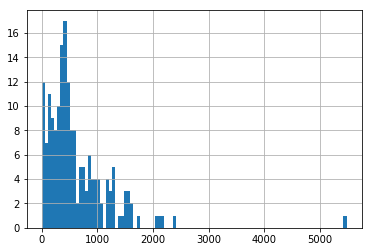

In [118]:
# convert 'first2last_funding_days' to classes and save as labels 0 to 7 (0 means no series b).
print(df.first2last_funding_days.describe())
df[df.first2last_funding_days>0].first2last_funding_days.hist(bins=100)
labels_ = pd.cut(x = df.first2last_funding_days, \
          bins = [-1, 0, 180, 360, 540, 720, 900, 1080, 10000], \
          labels = [0, 1, 2, 3, 4, 5, 6, 7])
# print(labels_)

In [89]:
# select all features that I think matters and convert them to numerical values.
# features that I think matters are:
# category_list, market, country_code, funding_total_usd, status, country_code, funding_rounds, founded_year, 
# all_tweet_num, preA_tweet_num, postA_tweet_num, preA_tweet_freq, postA_tweet_freq, preA_tweet_avglength, 
# postA_tweet_avglength, preA_tweet_content_richness, postA_tweet_content_richness, preA_tweet_interactiveness,
# postA_tweet_interactiveness

import re

# division of category_list column.
all_categories = []
for category_list in df.category_list.fillna('|').tolist():
    categories = re.split('\||\+', category_list)
    for category in categories:
        all_categories.append(category)
print(len(set(all_categories)))

354


In [90]:
# division of market column.
all_markets = []
for market in df.market.fillna('+').tolist():
    markets = re.split('\+', market)
    for market_ in markets:
        all_markets.append(market_)
print(len(set(all_markets)))

158


catetory_list and market column requires clustering using nlp to convert them to features. Save that for later for now.

In [119]:
# feature engineering.
df['funding_total_usd']
df['status_feature'] = df['status'].map({'closed': 0, 'operating': 1, 'acquired': 2}).fillna(0)
df['country_feature'] = df['country_code'].apply(lambda x: 1 if x=='USA' else 0)
df['age_feature'] = (pd.to_datetime('2014-12-31') - pd.to_datetime(df.founded_at)).dt.days
df['age_feature'] = df['age_feature'].fillna(df['age_feature'].mean())
# df['funding_rounds']
df['days_since_first_funding'] = (pd.to_datetime('2014-12-31') - pd.to_datetime(df.first_funding_at)).dt.days
# df['days_since_last_funding'] = (pd.to_datetime('2014-12-31') - pd.to_datetime(df.last_funding_at)).dt.days
df['all_tweet_num'] = df['all_tweet_num'].fillna(0)
df['preA_tweet_num'] = df['preA_tweet_num'].fillna(0)
df['postA_tweet_num'] = df['postA_tweet_num'].fillna(0)
df['preA_tweet_freq'] = df['preA_tweet_freq'].fillna(0)
df['postA_tweet_freq'] = df['postA_tweet_freq'].fillna(0)
df['preA_tweet_avglength'] = df['preA_tweet_avglength'].fillna(0)
df['postA_tweet_avglength'] = df['postA_tweet_avglength'].fillna(0)
df['preA_tweet_content_richness'] = df['preA_tweet_content_richness'].fillna(0)
df['postA_tweet_content_richness'] = df['postA_tweet_content_richness'].fillna(0)
df['preA_tweet_interactiveness'] = df['preA_tweet_interactiveness'].fillna(0)
df['postA_tweet_interactiveness'] = df['postA_tweet_interactiveness'].fillna(0)

In [135]:
# dividing training set and test set.
new_df = df[['funding_total_usd', 'status_feature', 'country_feature', 'age_feature', \
             'days_since_first_funding', 'all_tweet_num', 'preA_tweet_num', 'postA_tweet_num', \
             'preA_tweet_freq', 'postA_tweet_freq', 'preA_tweet_avglength', 'postA_tweet_avglength', \
             'preA_tweet_content_richness', 'postA_tweet_content_richness', 'preA_tweet_interactiveness', \
             'postA_tweet_interactiveness']].copy()
X = new_df.values
y = labels_.values # multi-class (time prediction)
# y = labels_.apply(lambda x: 1 if x>0 else 0).values # binary class (success prediction)
print(len(X), len(y))

X_train, y_train = X[:400, :], y[:400]
X_test, y_test = X[400:, :], y[400:]

515 515


In [136]:
# Logistic regression.
from sklearn.linear_model import LogisticRegression

# all parameters not specified are set to their defaults
logreg = LogisticRegression(random_state=0)
logreg.fit(X_train, y_train)
score = logreg.score(X_test, y_test)
print(score)
print(logreg.predict(X_test))

0.6434782608695652
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 3 0 0]


/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


This is a bad results, given the large number of negative examples in my dataset. Therefore, I will need to improve on the feature engineering part a lot in the future.

For now, I wwant to save my dataset and pre-trained model, for the purpose of building a prediction pipeline quickly.

In [141]:
# save dataframe.
new_df['a2b_series_time_label'] = labels_
new_df['permalink'] = company_df['permalink']
new_df['name'] = company_df['name']
# new_df.to_csv(processed_data_dir + '/model_logreg1_data.csv', index=False)

In [151]:
# save trained model.
import pickle
processed_data_dir = '/Users/caihao/Dropbox/Insight_Jan2020/data/processed'
with open(processed_data_dir + '/model_logreg1.pkl', 'wb') as f:
    pickle.dump(logreg, f)

new_logreg = pickle.load(open(processed_data_dir + '/model_logreg1.pkl', 'rb'))
print(new_logreg.predict(X_test))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 3 0 0]
